<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Word-Frequency-Classes" data-toc-modified-id="Word-Frequency-Classes-1">Word Frequency Classes</a></span><ul class="toc-item"><li><span><a href="#Unigrams" data-toc-modified-id="Unigrams-1.1">Unigrams</a></span></li><li><span><a href="#Skipgrams" data-toc-modified-id="Skipgrams-1.2">Skipgrams</a></span></li></ul></li><li><span><a href="#Frequency-Matrix-Functions" data-toc-modified-id="Frequency-Matrix-Functions-2">Frequency Matrix Functions</a></span><ul class="toc-item"><li><span><a href="#Pairwise-Frequency-Matrix" data-toc-modified-id="Pairwise-Frequency-Matrix-2.1">Pairwise Frequency Matrix</a></span></li><li><span><a href="#Pointwise-Mutual-Information-Matrix" data-toc-modified-id="Pointwise-Mutual-Information-Matrix-2.2">Pointwise Mutual Information Matrix</a></span></li><li><span><a href="#Embeddings-Matrix" data-toc-modified-id="Embeddings-Matrix-2.3">Embeddings Matrix</a></span></li></ul></li><li><span><a href="#Apply-to-some-real-data" data-toc-modified-id="Apply-to-some-real-data-3">Apply to some real data</a></span><ul class="toc-item"><li><span><a href="#Load-and-preprocess-Reuters-data-set" data-toc-modified-id="Load-and-preprocess-Reuters-data-set-3.1">Load and preprocess Reuters data set</a></span></li><li><span><a href="#Gather-Corpus-Skipgram-Frequencies" data-toc-modified-id="Gather-Corpus-Skipgram-Frequencies-3.2">Gather Corpus Skipgram Frequencies</a></span><ul class="toc-item"><li><span><a href="#Plot-Unigram-Statistics" data-toc-modified-id="Plot-Unigram-Statistics-3.2.1">Plot Unigram Statistics</a></span></li></ul></li><li><span><a href="#Convert-Skipgram-Frequencies-to-PMI-Matrix" data-toc-modified-id="Convert-Skipgram-Frequencies-to-PMI-Matrix-3.3">Convert Skipgram Frequencies to PMI Matrix</a></span></li><li><span><a href="#Convert-Skipgram-Frequencies-to-Embeddings" data-toc-modified-id="Convert-Skipgram-Frequencies-to-Embeddings-3.4">Convert Skipgram Frequencies to Embeddings</a></span></li><li><span><a href="#Simple-Nearest-Neighbors-Index" data-toc-modified-id="Simple-Nearest-Neighbors-Index-3.5">Simple Nearest Neighbors Index</a></span><ul class="toc-item"><li><span><a href="#Nearest-Neighbors-for-the-Reuters-Corpus" data-toc-modified-id="Nearest-Neighbors-for-the-Reuters-Corpus-3.5.1">Nearest Neighbors for the Reuters Corpus</a></span></li></ul></li><li><span><a href="#Train-Simple-Classifier" data-toc-modified-id="Train-Simple-Classifier-3.6">Train Simple Classifier</a></span></li><li><span><a href="#Toy-Example-Figure" data-toc-modified-id="Toy-Example-Figure-3.7">Toy Example Figure</a></span></li></ul></li></ul></div>

## Word Frequency Classes

### Unigrams

In [503]:
from collections import Counter
class UnigramFrequencies(object):
    """Simple Unigram frequency calculator
    
    Parameters
    ----------
    documents : list[list[str]]
        A list of documents, each document being a list of strings
    min_frequency : int
        The minimum frequency a word must occur in `documents` in order to
        be included in the skipgram analysis. If None provided, no minimum
        cutoff is used.
    max_frequency : int
        The maximum frequency a word must occur in `documents` in order to
        be included in the skipgram analysis. If None provide, no maximum
        cutoff is used.
    """
    def __init__(self, documents=None, min_frequency=5, max_frequency=None):
        self.unigram_counts = Counter()
        self.min_frequency = min_frequency
        self.max_frequency = max_frequency
        
        for ii, doc in enumerate(documents):
            self.unigram_counts.update(doc)
            
        if min_frequency is not None:
            for token, token_count in self.unigram_counts.most_common()[::-1]:
                if token_count < min_frequency:
                    del self.unigram_counts[token]
                # No need to search entire vocabulary
                if token_count >= min_frequency:
                    break

        if max_frequency is not None:
            for token, token_count in self.unigram_counts.most_common():
                if token_count > max_frequency:
                    del self.unigram_counts[token]
                # No need to search entire vocabulary
                if token_count <= max_frequency:
                    break
        

        self.token_to_idx = {tok: indx for indx, tok in enumerate(self.unigram_counts.keys())}
        self.idx_to_token = {indx: tok for tok, indx in self.token_to_idx.items()}
            
    def __getitem__(self, item):
        if isinstance(item, str):
            return self.unigram_counts[item]
        elif isinstance(item, int):
            return self.unigram_counts[self.idx_to_token[item]]
        raise ValueError(f"type {type(item)} not supported")

In [511]:
ufs = UnigramFrequencies(corpus, min_frequency=5, max_frequency=3000)

### Skipgrams

In [518]:
class SkipgramFrequencies(object):
    """Simple skipgrams frequency calculator
    
    Parameters
    ----------
    documents : list[list[str]]
        A list of documents, each document being a list of strings
    backward_window_size : int
        The number of words to the left used to define the context window
    forward_window_size : int
        The number of words to the right used to define the context window
    min_frequency : int
        The minimum frequency a word must occur in `documents` in order to
        be included in the skipgram analysis. If None provided, no minimum
        cutoff is used.
    max_frequency : int
        The maximum frequency a word must occur in `documents` in order to
        be included in the skipgram analysis. If None provide, no maximum
        cutoff is used.
    """
    def __init__(
        self,
        documents,
        backward_window_size=2,
        forward_window_size=2,
        min_frequency=5,
        max_frequency=None,
    ):
        self.backward_window_size = backward_window_size
        self.forward_window_size = forward_window_size
        self.skipgram_counts = Counter()

        # Independent word frequencies
        self.unigrams = UnigramFrequencies(
            documents,
            min_frequency=min_frequency,
            max_frequency=max_frequency
        )
        
        # Conditional word-context frequencies
        for doc_idx, doc in enumerate(documents):
            token_idxs = [self.token_to_idx[token] for token in doc if token in self.token_to_idx]
            n_document_tokens = len(token_idxs)
                       
            for token_idx, _ in enumerate(token_idxs):
                context_window_start = max(0, token_idx - self.backward_window_size)
                context_window_end = min(n_document_tokens - 1, token_idx + self.forward_window_size) + 1
                context_idxs = [
                    context_idx for context_idx in range(context_window_start, context_window_end) 
                    if context_idx != token_idx and context_idx in self.idx_to_token
                ]
                for context_idx in context_idxs:
                    skipgram = (token_idxs[token_idx], token_idxs[context_idx])
                    self.skipgram_counts[skipgram] += 1
                
    @property
    def idx_to_token(self):
        return self.unigrams.idx_to_token
    
    @property
    def token_to_idx(self):
        return self.unigrams.token_to_idx

## Frequency Matrix Functions
The functions get applied to skipgrams in order to calcualte various frequncy matrices:

### Pairwise Frequency Matrix

In [3]:
import numpy as np
from scipy.sparse import csr_matrix

def calculate_pairwise_frequency_matrix(skipgrams, recalculate=False):
    """Given a SkipgramFrequencies instance, returns the associated pairwise frequency counts
    as a sparse matrix
    """
    row_idxs = []
    col_idxs = []
    matrix_values = []
    for (token_idx_1, token_idx_2), skipgram_count in skipgrams.skipgram_counts.items():
        row_idxs.append(token_idx_1)
        col_idxs.append(token_idx_2)
        matrix_values.append(skipgram_count)

    return csr_matrix((matrix_values, (row_idxs, col_idxs)))

### Pointwise Mutual Information Matrix

In [24]:
def calculate_pmi_matrix(skipgrams, enforce_positive=False, recalculate=False):
    """Given a SkipgramFrequencies instance, returns the associated pointwise
    mutual information (PMI) matrix in sparse (CSR) format
    """
    # Get frequency matrix
    frequency_matrix = calculate_pairwise_frequency_matrix(skipgrams)

    # Precalculate some resusable things
    n_skipgrams = frequency_matrix.sum()
    word_sums = np.array(frequency_matrix.sum(axis=0)).flatten()
    context_sums = np.array(frequency_matrix.sum(axis=1)).flatten()
    
    # Sparse matrix components
    row_idxs = []
    col_idxs = []
    matrix_values = []

    for (skipgram_word_idx, skipgram_context_idx), skipgram_count in skipgrams.skipgram_counts.items():
         # p(w, c)
        join_probability = skipgram_count / n_skipgrams

        # p(w)
        n_word = context_sums[skipgram_word_idx]
        p_word = n_word / n_skipgrams

        # p(c)
        n_context = word_sums[skipgram_context_idx]
        p_context = n_context / n_skipgrams 
    
        # Pointwise mututal information = log[p(w, c) / p(w)p(c)]
        pmi = np.log(join_probability / (p_word * p_context))
        
        # Update sparse matrix entries
        row_idxs.append(skipgram_word_idx)
        col_idxs.append(skipgram_context_idx)
        matrix_values.append(pmi)

    return csr_matrix((matrix_values, (row_idxs, col_idxs)))


### Embeddings Matrix

In [28]:
from sklearn.decomposition import TruncatedSVD

def calculate_word_vectors(stats, n_dim=128):
    """Calculates word embedding vectors as the left singular vectors of 
    Singular Value Decomposition of the Pointwise Mutual Information Matrix.
    Singular vectors are rescaled by the inverse of the eigenvalues of the
    PMI correlation matrix
    """
    # Get PMI matrix
    if isinstance(stats, SkipgramFrequencies):
        pmi_matrix = calculate_pmi_matrix(stats)
    elif isinstance(stats, csr_matrix):
        pmi_matrix = stats

    # Alternatively, we could use scipy.sparse.linalg.svds / arpack algorithm,
    # but the Halko (2009) algorithm used by default generally scales better
    # on my laptop.
    svd = TruncatedSVD(n_components=n_dim, n_iter=50)

    # Use left singular vectors of PMI, scaled by singular values as embeddings
    U = svd.fit_transform(pmi_matrix)
    return U * np.sqrt(svd.singular_values_)


## Apply to some real data

### Load and preprocess Reuters data set

In [577]:
from sklearn.datasets import fetch_20newsgroups
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
STOPWORDS = stopwords.words('english')
PUNCTUATION = set(list(punctuation))

def valid_token(token):
    """Basic token filtering for 20 Newgroup task. Results in cleaner embeddings
    and faster convergence. Removes stopwords and any punctuation
    """
    if token in STOPWORDS:
        return False
    if any([t in PUNCTUATION for t in list(token)]):
        return False
    return True

def preprocess(document):
    """Simple preprocessing"""
    return [w for w in word_tokenize(document.lower()) if valid_token(w)]

# Compare results to 20 newsgroup https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html
dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers'))
corpus = [preprocess(doc) for doc in dataset.data]

### Gather Corpus Skipgram Frequencies

#### Plot Unigram Statistics

In [579]:
skipgram_frequencies = SkipgramFrequencies(corpus, min_frequency=10, max_frequency=3000)

In [580]:
ranked = skipgram_frequencies.unigrams.unigram_counts.most_common()
common_words, common_frequency = [z for z in zip(*ranked[:50])]
least_common_words, least_common_frequency = [z for z in zip(*ranked[-50:])]

Text(0.5, 1.0, 'Least Frequent')

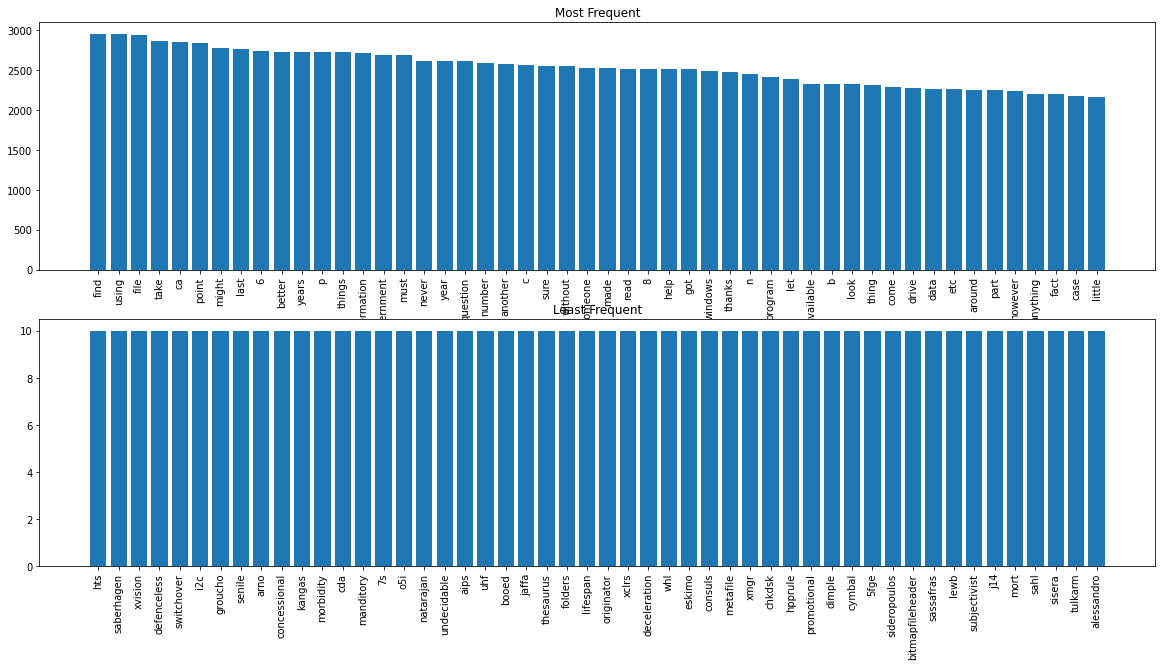

In [581]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
plt.sca(axs[0])
plt.bar(range(50), common_frequency)
plt.xticks(range(50), labels=common_words, rotation=90);
plt.title("Most Frequent")

plt.sca(axs[1])
plt.bar(range(50), least_common_frequency)
plt.xticks(range(50), labels=least_common_words, rotation=90);
plt.title("Least Frequent")

### Convert Skipgram Frequencies to PMI Matrix

In [596]:
pmi_matrix = calculate_pmi_matrix(skipgram_frequencies)

In [639]:
query = 'king'
query_idx = skipgram_frequencies.token_to_idx[query]
query_row = pmi_matrix[query_idx,:].toarray()[0]
[(skipgram_frequencies.idx_to_token[idx], query_row[idx]) for idx in np.argsort(query_row)[-20:][::-1]]

[('rodney', 6.787447474516449),
 ('insinuating', 6.430772530577716),
 ('cecil', 6.232946787247796),
 ('turgeon', 5.928315156482242),
 ('luther', 5.688835185848339),
 ('solomon', 5.642315170213446),
 ('hogue', 5.619842314361387),
 ('judah', 5.48169197588057),
 ('cyrus', 5.419171618899236),
 ('gideon', 5.407872063645303),
 ('ferraro', 5.401153113396558),
 ('barnes', 5.383453536297156),
 ('king', 5.282048200482259),
 ('dick', 5.229929619260708),
 ('residential', 5.142918242271078),
 ('flatley', 5.044478169457825),
 ('jonathan', 4.929476776763319),
 ('dish', 4.9266951338014415),
 ('noah', 4.9266951338014415),
 ('aap', 4.8992961596133275)]

### Convert Skipgram Frequencies to Embeddings

In [582]:
embeddings_matrix = calculate_word_vectors(skipgram_frequencies, n_dim=256)

In [583]:
embeddings_matrix.shape

(19699, 256)

### Simple Nearest Neighbors Index

In [584]:
from scipy.spatial.distance import cosine as cosine_similarity

class MatrixNearestNeighborsIndex(object):
    """Simple nearest neighbors index based on a pre-calculated matrix of item vectors.
    
    Parameters
    -----------
    matrix : ndarry or sparse array
        n_items x n_dims matrix of item represation
    idx_to_token : dict
        Mapping between matrix row indices and tokens
    token_to_idx : dict
        Mapping between tokens and matrix row indices
        
    Notes
    -----
    For simplicity, could probably infer token_to_idx from idx_to_token, but meh
    """
    def __init__(self, matrix, idx_to_token, token_to_idx):
        self.matrix = matrix
        self.idx_to_token = idx_to_token
        self.token_to_idx = token_to_idx
    
    def most_similar_from_label(self, query_label, n=20, return_self=False):
        query_idx = self.token_to_idx.get(query_label, None)
        if query_idx is not None:
            return self.most_similar_from_index(query_idx, n=n, return_self=return_self)
    
    def most_similar_from_index(self, query_idx, n=20, return_self=False):
        query_vector = self.get_vector_from_index(query_idx)
        return self.most_similar_from_vector(query_vector, n=n, query_idx=query_idx if not return_self else None)
        
    def most_similar_from_vector(self, query_vector, n=20, query_idx=None):
        if isinstance(self.matrix, csr_matrix):
            sims = cosine_similarity(self.matrix, query_vector).flatten()
        else:
            sims = self.matrix.dot(query_vector)
        
        sim_idxs = np.argsort(-sims)[:n + 1]
        sim_idxs = [idx for idx in sim_idxs if (query_idx is None or (query_idx is not None) and (idx != query_idx))]
        sim_word_scores = [(self.idx_to_token[sim_idx], sims[sim_idx]) for sim_idx in sim_idxs[:n]]
        return sim_word_scores
    
    def get_vector_from_label(self, label):
        query_idx = self.token_to_idx.get(label, None)
        if query_idx is not None:
            return self.get_vector_from_index(query_idx)
        else:
            return np.zeros(self.matrix.shape[1]) 
    
    def get_vector_from_index(self, query_idx):
        if isinstance(self.matrix, csr_matrix):
            return self.matrix.getrow(query_idx)
        else:
            return self.matrix[query_idx]
        
    def __getitem__(self, item):
        if isinstance(item, int):
            return self.get_vector_from_index(item)
        elif isinstance(item, str):
            return self.get_vector_from_label(item)
        
    def __contains__(self, item):
        return item in self.token_to_idx


#### Nearest Neighbors for the Reuters Corpus

In [585]:
nns = MatrixNearestNeighborsIndex(
    embeddings_matrix,
    skipgram_frequencies.idx_to_token,
    skipgram_frequencies.token_to_idx
)

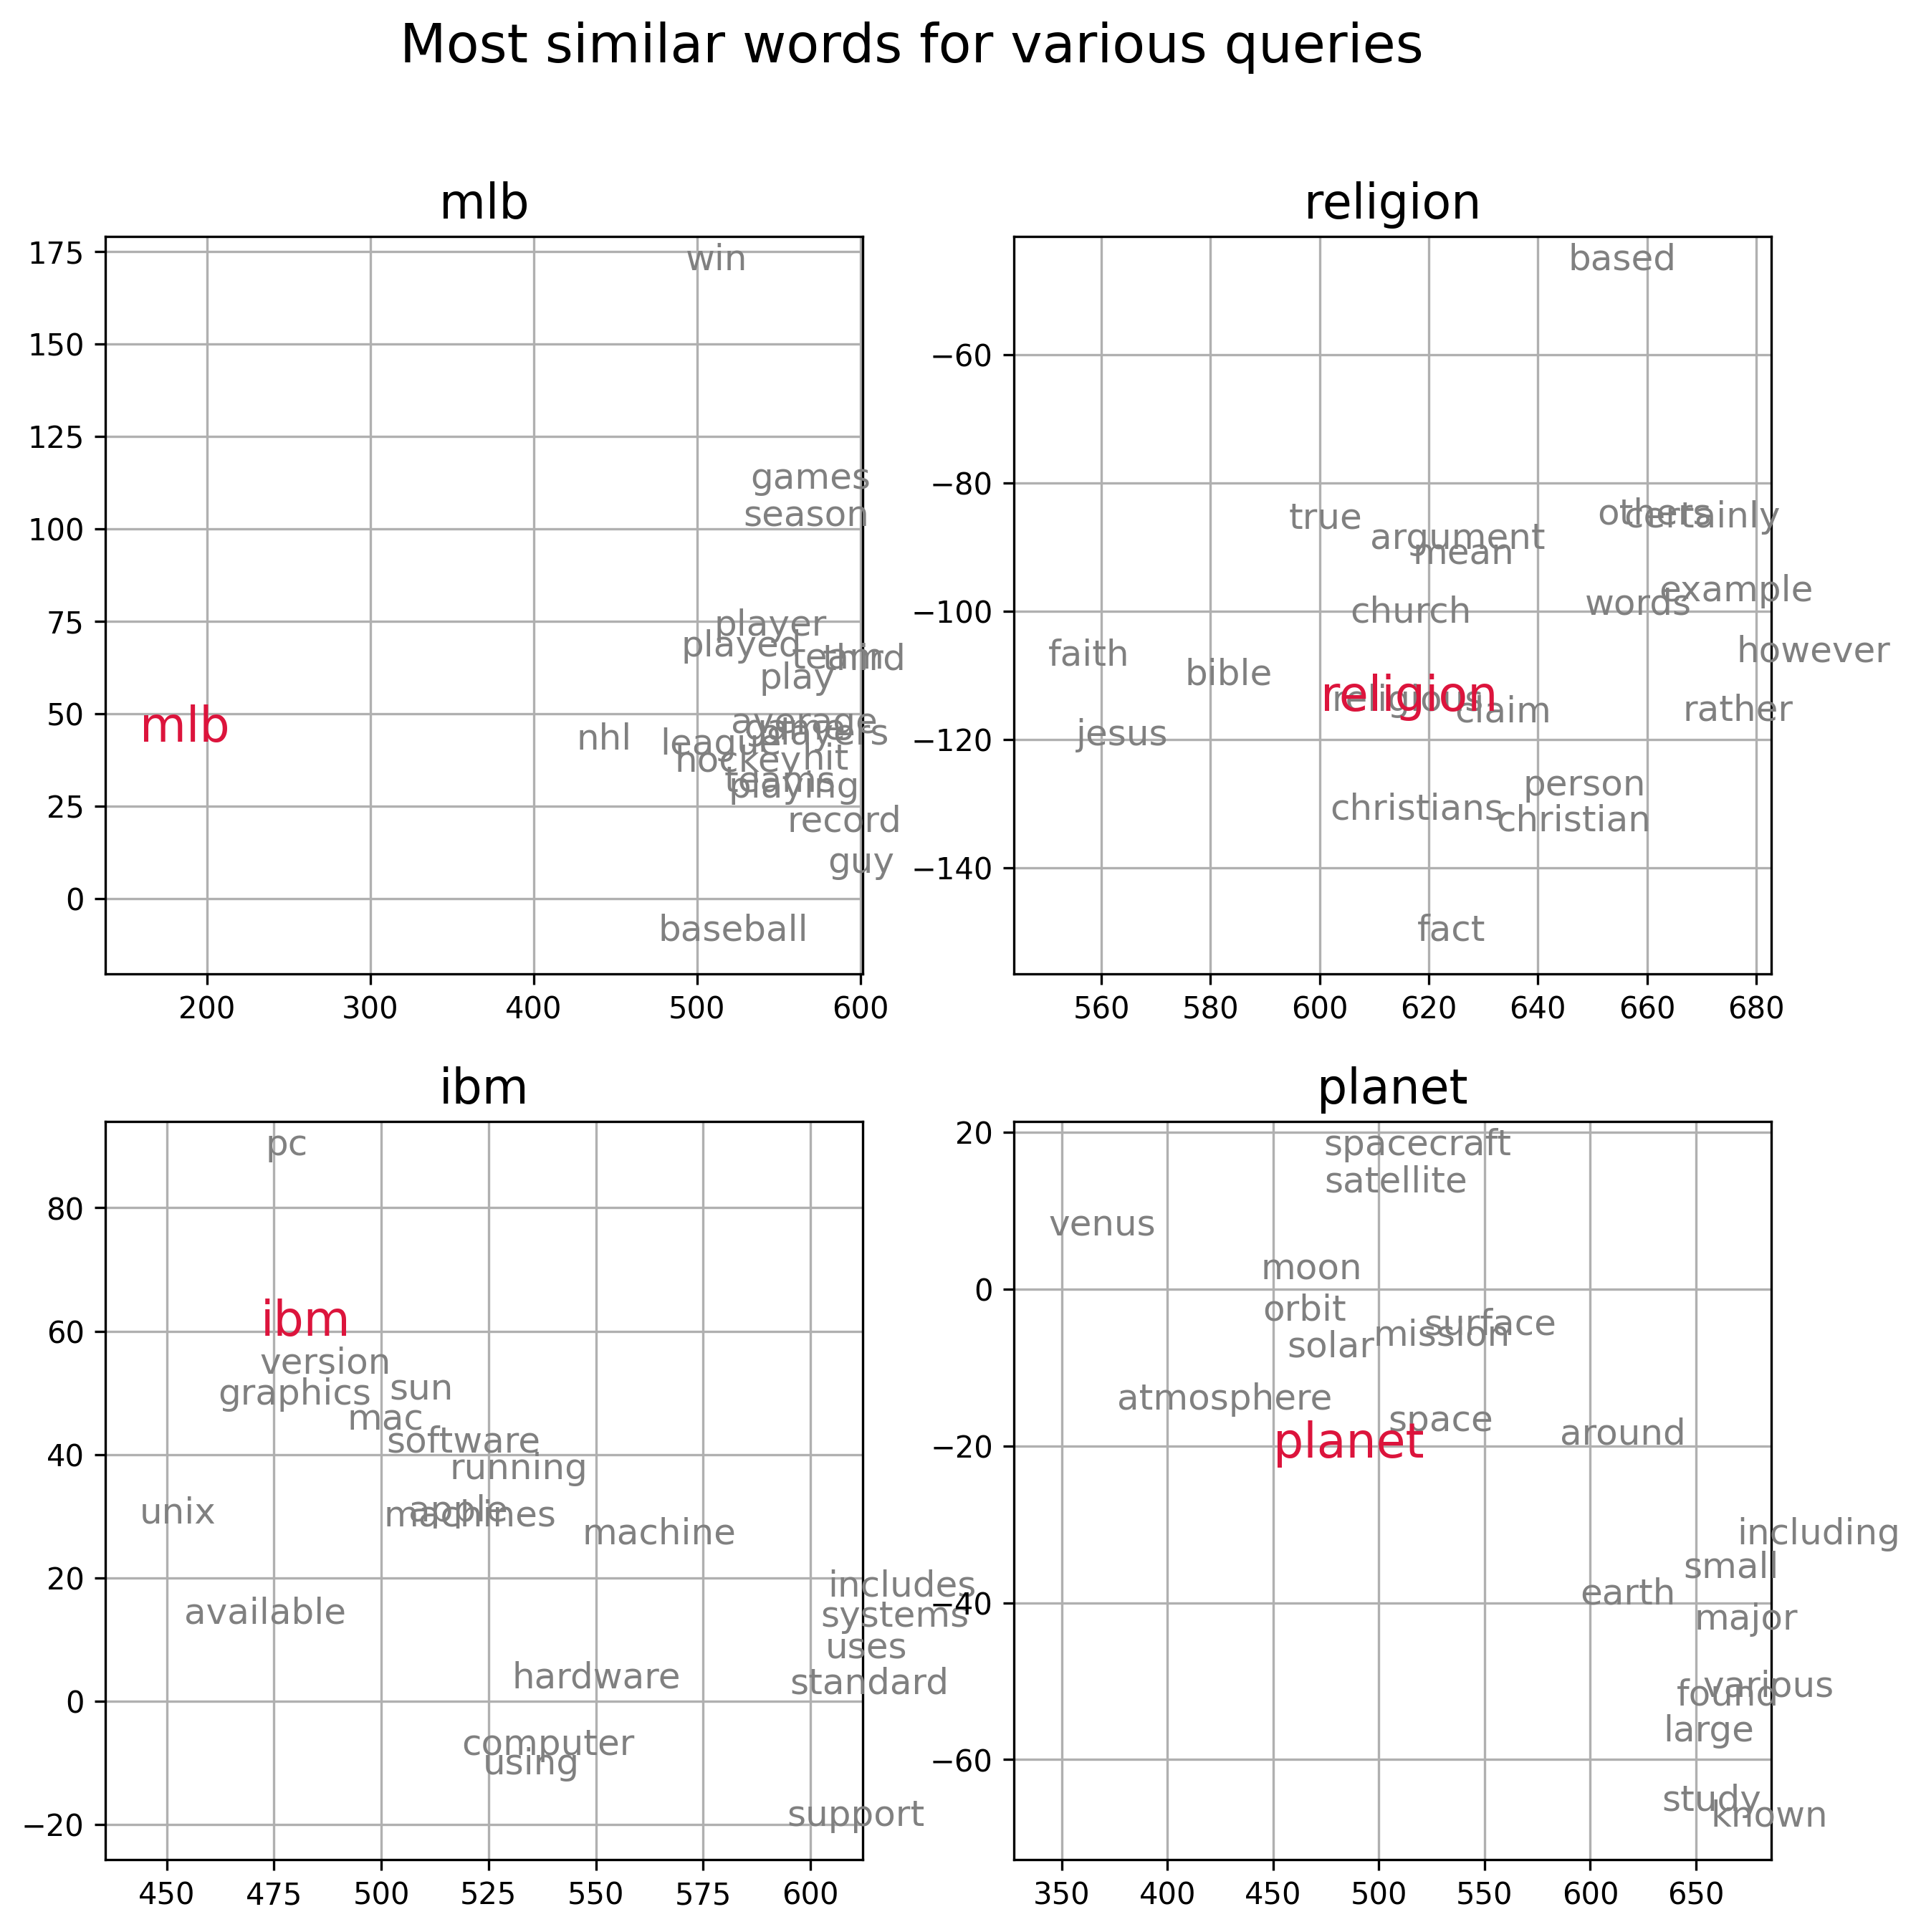

In [586]:
from matplotlib import pyplot as plt
def plot_label(xy, label, color='gray', fontsize=12):
    plt.plot(xy[0], xy[1], c=color)
    plt.text(xy[0], xy[1], label, c=color, fontsize=fontsize)

labels = ['mlb', 'religion', 'ibm', 'planet']
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=300)        

for ii, ax in enumerate(axs.ravel()):
    label = labels[ii]
    plt.sca(ax)
    most_similar = nns.most_similar_from_label(label)
    for sim_label, sim_score in most_similar:
        xy = nns.matrix[nns.token_to_idx[sim_label]][:2]
        plot_label(xy, sim_label)

    xy = nns.matrix[nns.token_to_idx[label]][:2]
    plot_label(xy, label, color='crimson', fontsize=16)
    plt.grid()
    plt.box('on')
    plt.title(label, fontsize=16)

plt.suptitle(f'Most similar words for various queries', fontsize=18)
plt.savefig('/tmp/most-similar.png', bbox_inches='tight')

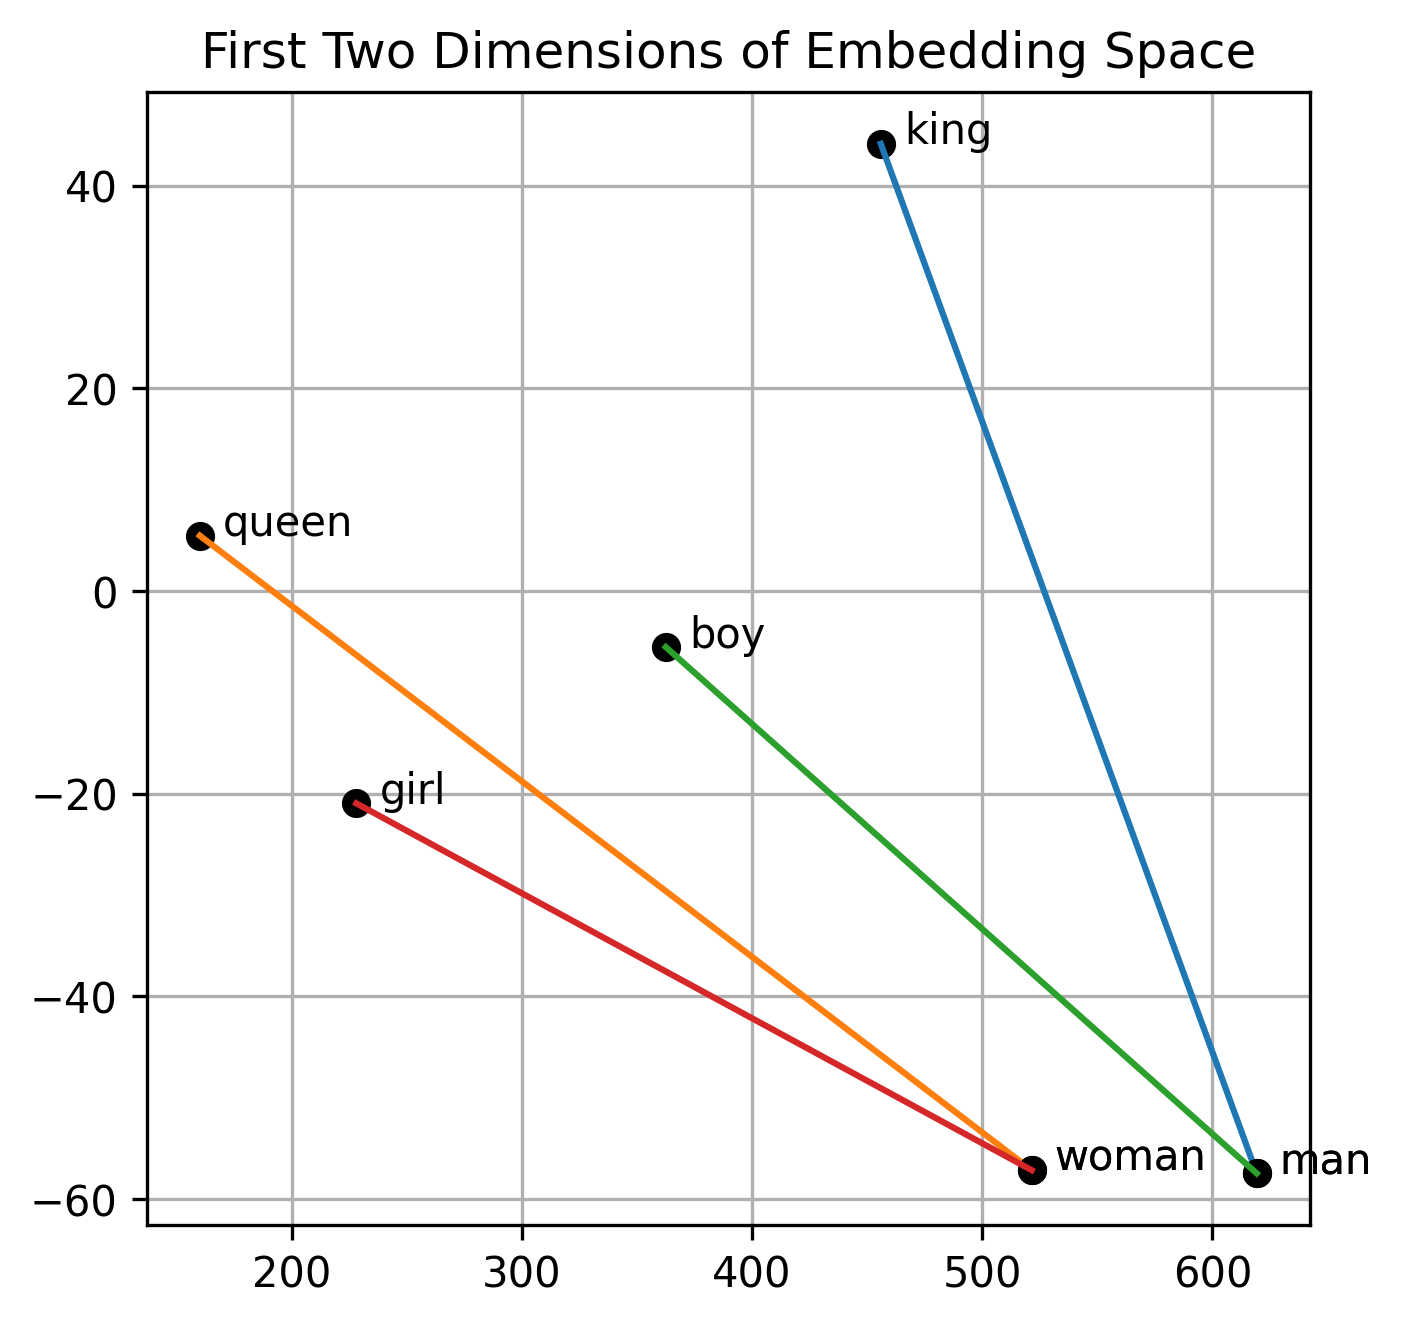

In [595]:
def plot_embeddings(sims, pairs):
    fig, axs = plt.subplots(figsize=(5, 5), dpi=300)
    plt.sca(axs)
    for labels in pairs:
        xys = []
        for ii, label in enumerate(labels):
            label_idx = sims.token_to_idx[label]
            x = sims.matrix[label_idx, 0]
            y = sims.matrix[label_idx, 1]
        
            plt.plot(x, y, 'o', c='black')
            plt.text(x + 10, y, label)
            xys.append([x, y])
        plt.plot([xys[0][0], xys[1][0]], [xys[0][1], xys[1][1]])
            
    plt.grid()
    plt.title('First Two Dimensions of Embedding Space')
    plt.savefig('/tmp/vector-analogy.png', bbox_inches='tight')
    
plot_embeddings(nns, [('king', 'man'), ('queen', 'woman'), ('boy', 'man'), ('girl', 'woman')])


In [808]:
def analogy(sims, positives, negatives=[], n=20):
    if isinstance(positives, str):
        positive = [positives]
        
    if isinstance(negatives, str):
        negatives = [negatives]
        
    vectors = []
    for p in positives:
        vectors.append(sims.get_vector_from_label(p))

    for n in negatives:
        vectors.append(-1 * sims.get_vector_from_label(n))
        
    avg_vector = np.sum(np.vstack(vectors), axis=0)
    return sims.most_similar_from_vector(avg_vector)
  
analogy(nns, ['boy', 'girl'], ['man'])

[('mamma', 69010.74514815237),
 ('boy', 65456.37168781142),
 ('apartment', 59370.436729434805),
 ('marina', 55838.710272035125),
 ('igor', 53969.42553580142),
 ('weekend', 52869.991489079635),
 ('balcony', 52807.376886433405),
 ('karina', 50771.46502486462),
 ('lyuda', 50164.01638319649),
 ('girl', 49628.86450017587),
 ('ran', 47510.57028951712),
 ('hospital', 46512.05693269357),
 ('bikes', 46340.6154044964),
 ('liked', 45018.71752274157),
 ('sumgait', 44398.60754858106),
 ('bed', 43763.42352321521),
 ('corner', 43126.49380774343),
 ('entryway', 42462.71375646173),
 ('garage', 42448.743464182284),
 ('riding', 41830.8644447539)]

### Train Simple Classifier

In [589]:
def featurize_document(document, nearest_neighbors):
    vectors = [nearest_neighbors[d] for d in document if d in nearest_neighbors]
    if vectors:
        return np.vstack(vectors).mean(0)
    return np.zeros_like(nearest_neighbors.matrix[0])

def featurize_corpus(corpus, nearest_neighbors):
    vectors = [featurize_document(document, nearest_neighbors) for document in corpus]
    return np.vstack(vectors)

# Featurize the text using our embeddings
features = featurize_corpus(corpus, nns)

In [590]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    features, dataset.target, range(len(dataset.target))
)

In [591]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=100, solver='sag').fit(X_train, y_train)
pred_test = clf.predict(X_test)

/Users/dustinstansbury/.local/share/virtualenvs/notebooks-I_qBHKH9/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [592]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred_test, target_names=dataset.target_names, output_dict=True)
print(classification_report(y_test, pred_test, target_names=dataset.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.60      0.65      0.62       186
           comp.graphics       0.67      0.65      0.66       248
 comp.os.ms-windows.misc       0.63      0.72      0.67       228
comp.sys.ibm.pc.hardware       0.73      0.64      0.68       241
   comp.sys.mac.hardware       0.74      0.75      0.74       230
          comp.windows.x       0.79      0.72      0.75       262
            misc.forsale       0.70      0.74      0.72       232
               rec.autos       0.85      0.80      0.83       251
         rec.motorcycles       0.83      0.84      0.83       255
      rec.sport.baseball       0.90      0.92      0.91       286
        rec.sport.hockey       0.94      0.94      0.94       258
               sci.crypt       0.82      0.82      0.82       250
         sci.electronics       0.66      0.68      0.67       256
                 sci.med       0.85      0.86      0.85       242
         

In [594]:
import pandas as pd
pd.DataFrame(class_report).T

,precision,recall,f1-score,support
alt.atheism,0.603015,0.645161,0.623377,186.000000
comp.graphics,0.672199,0.653226,0.662577,248.000000
comp.os.ms-windows.misc,0.633205,0.719298,0.673511,228.000000
comp.sys.ibm.pc.hardware,0.733333,0.639004,0.682927,241.000000
comp.sys.mac.hardware,0.735043,0.747826,0.741379,230.000000
comp.windows.x,0.790795,0.721374,0.754491,262.000000
misc.forsale,0.704918,0.741379,0.722689,232.000000
rec.autos,0.848739,0.804781,0.826176,251.000000
rec.motorcycles,0.828794,0.835294,0.832031,255.000000
rec.sport.baseball,0.900344,0.916084,0.908146,286.000000


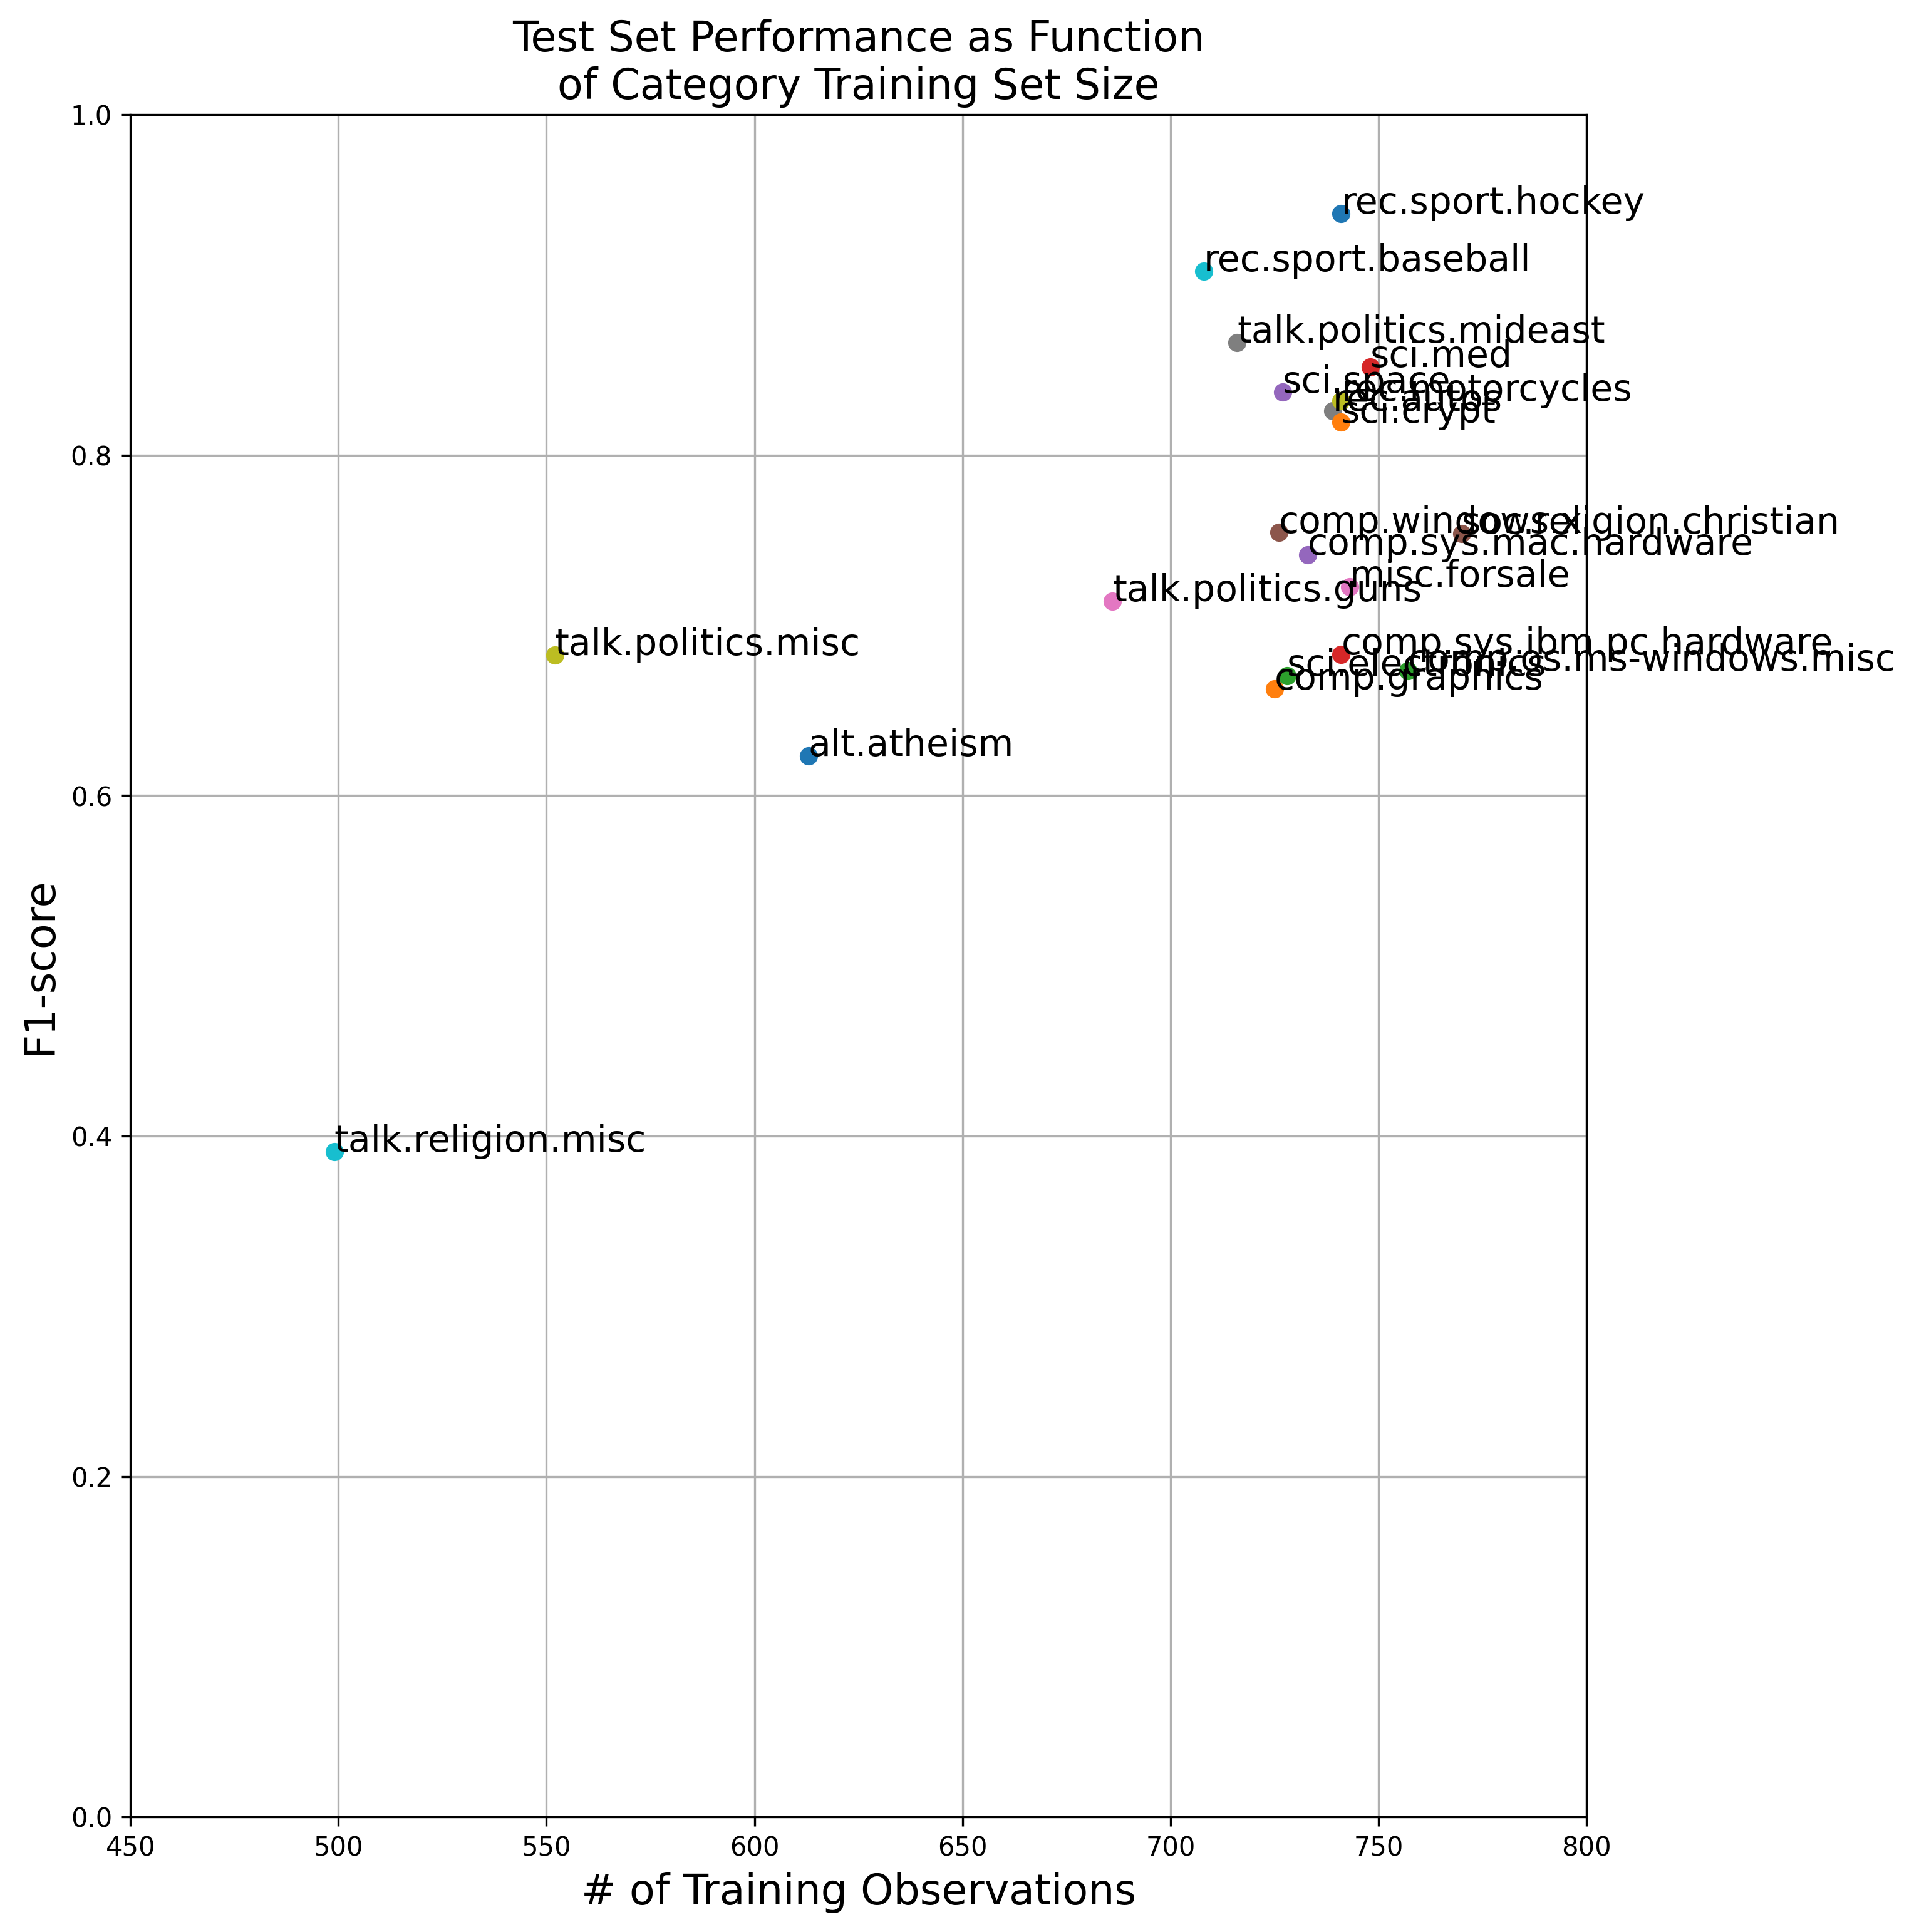

In [593]:
# Get number of training observations associates with each category
n_training_observations = Counter(y_train)
n_training_observations_per_category = {dataset.target_names[k]: n_training_observations[k] for k in n_training_observations.keys()}

# Plot relationship between Test Set F1 and # of training observations per category
plt.subplots(figsize=(10, 12), dpi=300)
for k, params in class_report.items():
    if k not in ('weighted avg', 'macro avg', 'accuracy'):
        plt.plot(n_training_observations_per_category[k], params['f1-score'], 'o')
        plt.text(n_training_observations_per_category[k], params['f1-score'], k, fontsize=14)
    plt.xlabel('# of Training Observations', fontsize=16)
    plt.ylabel('F1-score', fontsize=16)
    plt.axis('tight')
plt.xlim([450, 800])
plt.ylim([.0, 1.])
plt.title('Test Set Performance as Function\nof Category Training Set Size', fontsize=16)    
plt.grid()
plt.savefig('/tmp/20newsgroup-performance.png', bbox_inches='tight')

### Toy Example Figure

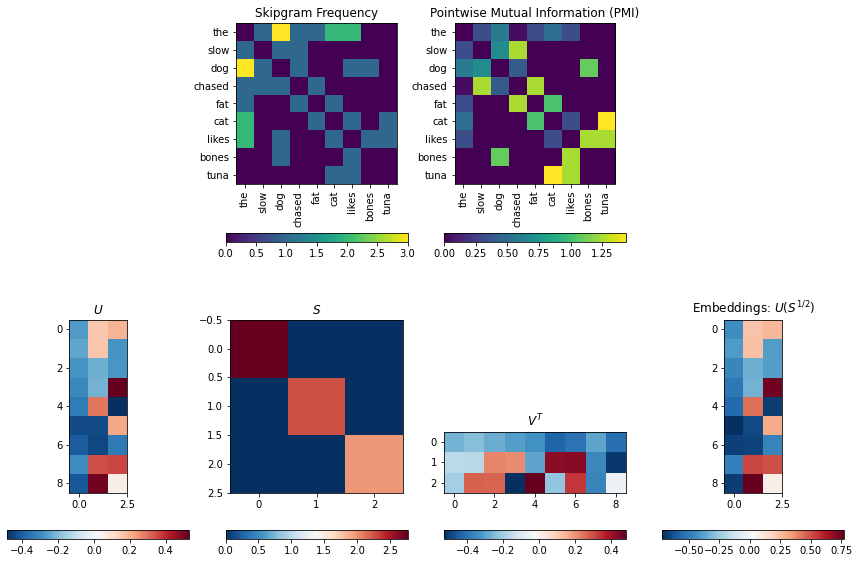

In [809]:
toy_corpus = [
    'the slow dog chased the fat cat',
    'the dog likes bones',
    'the cat likes tuna'
]
toy_corpus = [c.split(" ") for c in toy_corpus]

# Calcualte the skipgram frequency matrix
toy_skigrams = SkipgramFrequencies(toy_corpus, min_frequency=0)
toy_frequency_matrix = calculate_pairwise_frequency_matrix(toy_skigrams)

# Calculate the PMI matrix
toy_pmi_matrix = calculate_pmi_matrix(toy_skigrams)

# Calculate embeddings
n_embedding_dims = 3  # D

# Calculate associated SVD (redundant, but meh)
U, S_, V = np.linalg.svd(toy_pmi_matrix.todense())

# Truncate at D
S = np.zeros((n_embedding_dims, n_embedding_dims))
np.fill_diagonal(S, S_[:n_embedding_dims])
U = U[:, :n_embedding_dims]
V = V[:n_embedding_dims, :]
toy_embeddings = U @ S ** .5

# Visualizations
fig, axs = plt.subplots(2, 4, figsize=(15, 10))

## Frequency matrix
plt.sca(axs[0][1])
plt.imshow(toy_frequency_matrix.todense())
plt.colorbar(orientation='horizontal', pad=.2)
tics = range(len(toy_skigrams.idx_to_token))
labels = [toy_skigrams.idx_to_token[ii] for ii in tics]
plt.xticks(tics, labels=labels, rotation=90)
plt.yticks(tics, labels=labels)
plt.title("Skipgram Frequency")

## PMI Matrix
plt.sca(axs[0][2])
plt.imshow(toy_pmi_matrix.todense())
plt.colorbar(orientation='horizontal', pad=.2)
plt.xticks(tics, labels=labels, rotation=90)
plt.yticks(tics, labels=labels)
plt.title("Pointwise Mutual Information (PMI)")

## Left singular vectors
plt.sca(axs[1][0])
plt.imshow(U, cmap='RdBu_r')
plt.colorbar(orientation='horizontal')
plt.title('$U$')

## Singular values
plt.sca(axs[1][1])
plt.imshow(S, cmap='RdBu_r')
plt.colorbar(orientation='horizontal')
plt.title("$S$")

## Right singular vectors
plt.sca(axs[1][2])
plt.imshow(V, cmap='RdBu_r')
plt.colorbar(orientation='horizontal')
plt.title("$V^T$")

## Resulting embeddings
plt.sca(axs[1][3])
plt.imshow(toy_embeddings, cmap='RdBu_r')
plt.title("Embeddings: $U(S^{1/2})$")
plt.colorbar(orientation='horizontal')

## Clear unused axes
plt.sca(axs[0][0])
plt.axis('off')
plt.sca(axs[0][3])
plt.axis('off')

plt.savefig('/tmp/toy-example.png', dpi=300, bbox_inches='tight')